<a href="https://colab.research.google.com/github/YumizSui/AJACS-PSP-2025/blob/main/notebooks/AJACS_Boltz_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# タンパク質立体構造予測の実践と応用 (Boltz-1)
リポジトリ: https://github.com/YumizSui/AJACS-PSP-2025

本Notebookでは、Google Colaboratory上で動作する[Boltz-1](https://github.com/jwohlwend/boltz)による立体構造予測例を示します。


まず、GPUが適切に設定されていることを確認します。  
以下のコマンドでエラーが生じる場合はメニューバーから「ランタイム」→「ランタイムのタイプを変更」→「T4 GPU」に切り替えてください

「ランタイム」→「すべてのセルを実行」をすれば自分で動くことが確認できます。

In [1]:
!nvidia-smi

Tue May 13 10:09:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 今回使用するライブラリの導入
!pip install boltz py3Dmol # ここでwarningがでるが、セッションを再起動する必要はありません

In [10]:
# 今回使うデータをダウンロード
!git clone https://github.com/YumizSui/AJACS-PSP-2025.git
%cd AJACS-PSP-2025

Cloning into 'AJACS-PSP-2025'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 6), reused 29 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 21.49 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/AJACS-PSP-2025


In [11]:
# 必要な関数・ライブラリをimport
from src.utils import show_results, create_pae_plot
import numpy as np

In [ ]:
import py3Dmol
def show_results(cif_file):
    view = py3Dmol.view(width=800, height=600)
    view.addModel(open(cif_file).read(), 'cif')

    view.setStyle({}, {'cartoon': {}})

    bins = [('90-100', '#0053D6'), ('70-90',  '#65CBF3'), ('50-70',  '#FFDB13'), ('0-50',   '#FF7D45'), ]
    for rng, col in bins:
        view.setStyle({'b': rng}, {'cartoon': {'color': col}})

    view.setStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})

    view.setBackgroundColor('white')
    view.zoomTo()
    return view

## タンパク質複合体予測の実行例

複合体の予測例。msaにファイルを指定することでMSA計算をスキップできる。
```yaml
version: 1  # Optional, defaults to 1
sequences:
  - protein:
      id: A
      sequence: MAHHHHHHVAVDAVSFTLLQDQLQSVLDTLSEREAGVVRLRFGLTDGQPRTLDEIGQVYGVTRERIRQIESKTMSKLRHPSRSQVLRDYLDGSSGSGTPEERLLRAIFGEKA
      msa: examples/msa/multimer_0.csv
  - protein:
      id: B
      sequence: MRYAFAAEATTCNAFWRNVDMTVTALYEVPLGVCTQDPDRWTTTPDDEAKTLCRACPRRWLCARDAVESAGAEGLWAGVVIPESGRARAFALGQLRSLAERNGYPVRDHRVSAQSA
      msa: examples/msa/multimer_1.csv
```

In [17]:
name="multimer"
inputfile=f"examples/{name}.yaml"
!boltz predict "$inputfile" --write_full_pae --out_dir "example_results"

Checking input data.
Running predictions for 1 structure
Processing input data.
100% 1/1 [00:00<00:00,  2.68it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-13 10:16:14.409048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747131374.447861   16561 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747131374.460447   16561 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 10:16:14.508150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follow

In [18]:
# 結果を出力
output_file = f"example_results/boltz_results_{name}/predictions/{name}/{name}_model_0.cif"
show_results(output_file)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

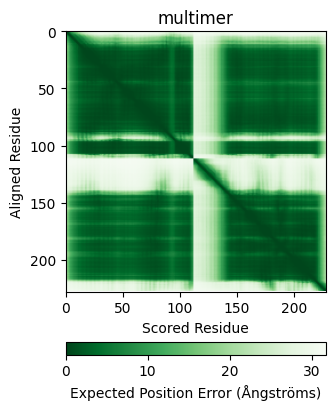

In [19]:
# 出力結果のpAEを可視化
result = np.load(f"example_results/boltz_results_{name}/predictions/{name}/pae_{name}_model_0.npz")
create_pae_plot(result, name)

## タンパク質リガンド複合体予測の実行例

アロステリックサイトに結合するリガンドの例として、[PDB ID: 2YHD](https://www.rcsb.org/structure/2YHD)の立体構造を行ってみる。
ポケットを明示的に指定してみる
```yaml
version: 1
sequences:
  - protein:
      id: A
      sequence: PIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPIARELHQFTFDLLIKSHMVSVDFPEMMAEIISVQVPKILSGKVKPIYFHTQ
      msa: examples/msa/P10275_0.csv
  - ligand: # allosteric
        id: C
        ccd: AV6
```

In [38]:
name="P10275_AL"
inputfile=f"examples/{name}.yaml"
!boltz predict "$inputfile" --write_full_pae --out_dir "example_results"

Checking input data.
Running predictions for 1 structure
Processing input data.
100% 1/1 [00:00<00:00,  4.87it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-13 10:41:44.367850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747132904.641112   23008 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747132904.718232   23008 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 10:41:45.323093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follow

オルソステリックサイトに予測されてしまっているはず

In [59]:
# 結果を出力
name="P10275_AL"
output_file = f"example_results/boltz_results_{name}/predictions/{name}/{name}_model_0.cif"
view = show_results(output_file)
view.addStyle({'resi': [46,64], 'chain': "A"}, {'stick': {'colorscheme': 'orangeCarbon'}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

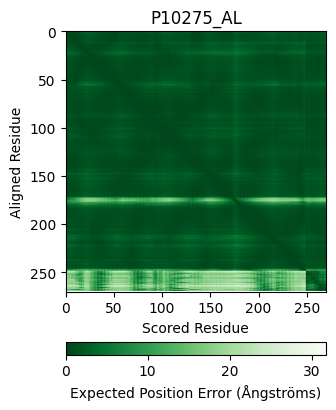

In [40]:
# 出力結果のpAEを可視化
result = np.load(f"example_results/boltz_results_{name}/predictions/{name}/pae_{name}_model_0.npz")
create_pae_plot(result, name)

## ポケット制約あり・タンパク質リガンド複合体予測の実行例

ポケットを明示的に指定してみる
```yaml
version: 1
sequences:
  - protein:
      id: A
      sequence: PIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPIARELHQFTFDLLIKSHMVSVDFPEMMAEIISVQVPKILSGKVKPIYFHTQ
      msa: examples/msa/P10275_0.csv
#   - ligand: # orthosteric
#       id: B
#       ccd: TES
  - ligand: # allosteric
        id: C
        ccd: AV6
constraints:
  - pocket:
      binder: C
      contacts: [ [ A, 46 ], [ A, 64 ] ] # 明示的にポケットを指定
```

In [41]:
name="P10275_AL_pocket"
inputfile=f"examples/{name}.yaml"
!boltz predict "$inputfile" --write_full_pae --out_dir "example_results"

Checking input data.
Running predictions for 1 structure
Processing input data.
100% 1/1 [00:00<00:00,  5.92it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-13 10:44:43.162559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747133083.193168   23829 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747133083.211306   23829 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 10:44:43.262356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follow

ポケット制約を指定することで、（当然ではあるものの）アロステリックサイトに予測することが出来た

In [60]:
# 結果を出力
name="P10275_AL_pocket"
output_file = f"example_results/boltz_results_{name}/predictions/{name}/{name}_model_0.cif"
view = show_results(output_file)
view.addStyle({'resi': [46,64], 'chain': "A"}, {'stick': {'colorscheme': 'orangeCarbon'}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

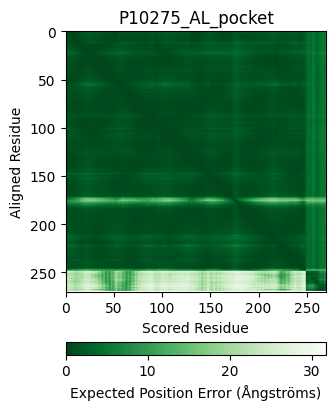

In [43]:
# 出力結果のpAEを可視化
result = np.load(f"example_results/boltz_results_{name}/predictions/{name}/pae_{name}_model_0.npz")
create_pae_plot(result, name)

## 環状ペプチド予測の実行例

`cyclic: true`とすることでHeaad−to−tail型の環状ペプチドを予測することが出来る。
なお、`msa: empty`とすればMSAを計算しない
```yaml
version: 1  # Optional, defaults to 1
sequences:
  - protein:
      id: A
      sequence: QLEDSEVEAVAKG
      cyclic: true
      msa: empty
```

In [24]:
name="cyclic_prot"
inputfile=f"examples/{name}.yaml"
!boltz predict "$inputfile" --write_full_pae --out_dir "example_results"

Checking input data.
Running predictions for 1 structure
Processing input data.
  0% 0/1 [00:00<?, ?it/s]Generating MSA for examples/cyclic_prot.yaml with 1 protein entities.

  0% 0/150 [00:00<?, ?it/s]
SUBMIT:   0% 0/150 [00:00<?, ?it/s]
COMPLETE:   0% 0/150 [00:00<?, ?it/s]
COMPLETE: 100% 150/150 [00:00<00:00, 340.38it/s]
100% 1/1 [00:00<00:00,  2.19it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-13 10:21:14.435599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747131674.463760   17866 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747131674.472485   17866 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBL

In [29]:
# 結果を出力
output_file = f"example_results/boltz_results_{name}/predictions/{name}/{name}_model_0.cif"
view = show_results(output_file)
view.setStyle({}, {'stick': {'colorscheme': 'blueCarbon', 'radius': 0.2}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

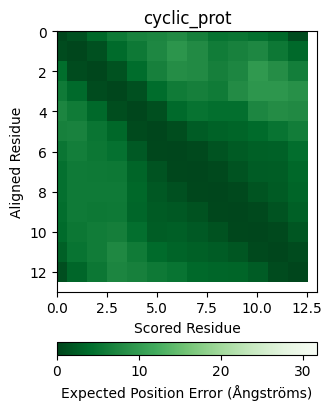

In [8]:
# 出力結果のpAEを可視化
import numpy as np
result = np.load(f"example_results/boltz_results_{name}/predictions/{name}/pae_{name}_model_0.npz")
create_pae_plot(result, name)

## グリコシル化（発展）
発展的な話題として、糖鎖付加されたタンパク質の立体構造予測を行う方法を示す。  
現状、最も手軽にアミノ酸への共有結合を扱う方法は、対応したcustom CCDを定義することである。  
[boltz-generalized-covalent-modification](https://github.com/benf549/boltz-generalized-covalent-modification)には、SMILESから参照アミノ酸に重ね合わせた立体構造を生成し、原子の名前を合わせ、Boltz-1の参照するCCDリストに登録する方法が示されてる。

以下では、この方法を用いて、グリコシル化されたアミノ酸を用いて翻訳後修飾を行う。  

対象とするタンパク質は、[PDB ID: 7BBV](https://www.rcsb.org/structure/7BBV)で、5つのThr残基と1つのSer残基がα-D-mannoseによってグリコシル化されている。


In [28]:
# カスタムCCDを定義
!python src/covalent_inference.py \
    "C[C@H]([C@@H](C(=O)O)N)O[C@@H]1[C@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O" \
    "THR" \
    "THMAN"

!python src/covalent_inference.py \
    "C([C@@H]1[C@H]([C@@H]([C@@H]([C@H](O1)OC[C@@H](C(=O)O)N)O)O)O)O" \
    "SER" \
    "SEMAN"


Loaded Boltz CCD cache from /root/.boltz/ccd.pkl
Found mapping between reference residue and NCAA molecule: {6: 'N', 2: 'CA', 3: 'C', 4: 'O', 1: 'CB', 7: 'OG1', 0: 'CG2', 5: 'OXT'}

Verifying atom ordering:
Atom 0: N - {'name': 'N', 'alt_name': 'N', 'leaving_atom': False}
Atom 1: C - {'_ChiralityPossible': 1, '_CIPCode': 'S', 'name': 'CA', 'alt_name': 'CA', 'leaving_atom': False}
Atom 2: C - {'name': 'C', 'alt_name': 'C', 'leaving_atom': False}
Atom 3: O - {'name': 'O', 'alt_name': 'O', 'leaving_atom': False}
Atom 4: C - {'_ChiralityPossible': 1, '_CIPCode': 'R', 'name': 'CB', 'alt_name': 'CB', 'leaving_atom': False}
Atom 5: O - {'name': 'OG1', 'alt_name': 'OG1', 'leaving_atom': False}
Atom 6: C - {'name': 'CG2', 'alt_name': 'CG2', 'leaving_atom': False}
Atom 7: O - {'name': 'OXT', 'alt_name': 'OXT', 'leaving_atom': True}
Atom 8: C - {'_ChiralityPossible': 1, '_CIPCode': 'S', 'name': 'C8', 'alt_name': 'C8', 'leaving_atom': False}
Atom 9: C - {'_ChiralityPossible': 1, '_CIPCode': 'S', '

上記で定義したCCDの名前でmodificationを設定
```yaml
version: 1
sequences:
  - protein:
      id: A1
      sequence: TPTPTIQEDGSPALIAKRASVTESCNIGYASTNGGTTGGKGGATTTVSTLAQFTKAAESSGKLNIVVKGKISGGAKVRVQSDKTIIGQKGSELVGTGLYINKVKNVIVRNMKISKVKDSNGDAIGIQASKNVWVDHCDLSSDLKSGKDYYDGLLDITHGSDWVTVSNTFLHDHFKASLIGHTDSNAKEDKGKLHVTYANNYWYNVNSRNPSVRFGTVHIYNNYYLEVGSSAVNTRMGAQVRVESTVFDKSTKNGIISVDSKEKGYATVGDISWGSSTNTAPKGTLGSSNIPYSYNLYGKNNVKARVYGTAGQTLGFAAASFLEQKLISEEDLNSAVDHHHHHH
      msa: examples/msa/7bbv_0.csv
      modifications:
        - position: 22
          ccd: THMAN
        - position: 44
          ccd: THMAN
        - position: 45
          ccd: THMAN
        - position: 46
          ccd: THMAN
        - position: 48
          ccd: SEMAN
        - position: 54
          ccd: THMAN
```

In [30]:
name="7bbv_ptm"
inputfile=f"examples/{name}.yaml"
!boltz predict "$inputfile" --use_msa_server --write_full_pae --out_dir "example_results"

Checking input data.
Running predictions for 1 structure
Processing input data.
100% 1/1 [00:00<00:00,  1.86it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-13 10:24:15.042183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747131855.070167   18689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747131855.079129   18689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 10:24:15.113683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follow

In [55]:
# 結果を出力
name="7bbv_ptm"
output_file = f"example_results/boltz_results_{name}/predictions/{name}/{name}_model_0.cif"
view = show_results(output_file)
# view.setStyle({'model': -1}, {'stick': {'colorscheme': 'blueCarbon', 'radius': 0.2}})
view.addStyle({'resi': [22,44,45,46,48,54]}, {'stick': {'colorscheme': 'blueCarbon'}}) # グリコシル化した残基

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

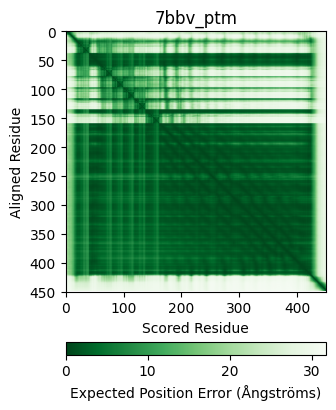

In [32]:
# 出力結果のpAEを可視化
import numpy as np
result = np.load(f"example_results/boltz_results_{name}/predictions/{name}/pae_{name}_model_0.npz")
create_pae_plot(result, name)